#### Modifying Bogus QVAPOR
 According to James, to get the convection and secondary TC cirulation spun up, we increase
 bogus wrfinput QVAPOR by 20% in TC center and decrease it to 0 3*rmax from TC center <br>
 Ming Ge May 2024

In [1]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from wrf import (getvar, ll_to_xy , xy_to_ll, interplevel, vertcross, 
                 vinterp, ALL_TIMES)

In [2]:
def plot_2d(lat, lon, data_2d, vmin, vmax, color_map, title_s):
    fig = plt.figure(figsize=(8,8))

    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())
    
    # Make a filled contour plot
    filled_c = ax.contourf(lon, lat, data_2d,
                           levels =np.arange(vmin, vmax, (vmax-vmin)/15), extend='both',
                           cmap = color_map, transform = ccrs.PlateCarree())

    # Add coastlines
    ax.coastlines()
    ax.add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
    ax.set_title(title_s)
    
    ax = plt.gca()
    ax.gridlines(draw_labels=True)   
    # or..
    #ax.set_xticks([-40, -20, 0, 20, 40], crs=ccrs.PlateCarree())

    # Add a colorbar for the filled contour.
    # and pad argument to set colorbar away from x-axis
    fig.colorbar(filled_c,  label= '', pad = 0.05, fraction=0.04, orientation="horizontal"); # 

#### read bogus wrfinput file

#### Create a mask, TC center 1.2, radius > rmax*3 1

15.608227 -156.3005 3000.0
CPU times: user 1min 2s, sys: 413 ms, total: 1min 2s
Wall time: 1min 3s


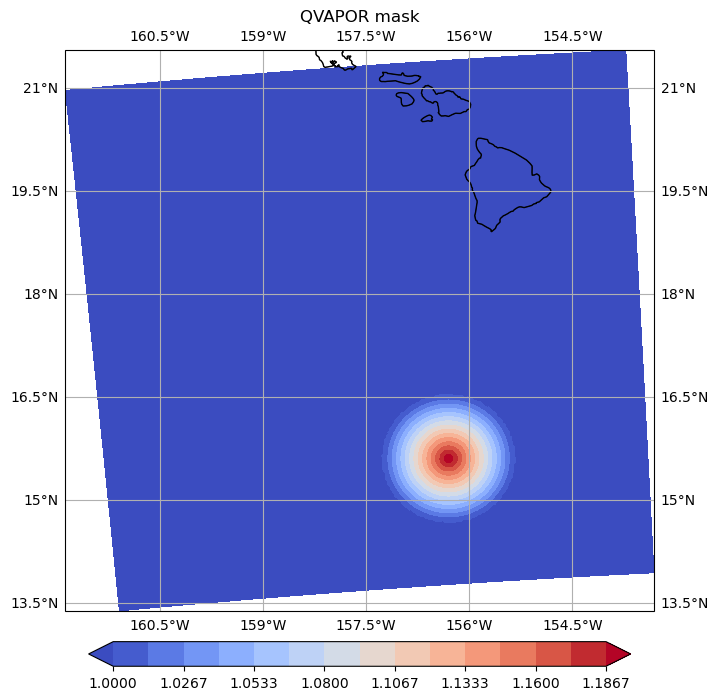

In [3]:
%%time

from netCDF4 import Dataset
latc_loc = 15.6
lonc_loc = -156.3
#vmax_meters_per_second = 64.3
rmax = 37000.0

r_mod = 100000 #rmax*3

flnm_wrf = '/glade/derecho/scratch/mingge/wrfv4.5.1/LANE_BOG/wrfinput_d01'
wrf_file = Dataset(flnm_wrf)

# TC center I,j
j_c, i_c = ll_to_xy(wrf_file, [latc_loc], [lonc_loc])

#lat = np.squeeze(wrf_file.variables['XLAT'][0])
lat_2d = wrf_file.variables['XLAT'][0]
lon_2d = wrf_file.variables['XLONG'][0]
dx = wrf_file.getncattr('DX')
print(lat_2d[i_c, j_c], lon_2d[i_c, j_c], dx)

n_i = lat_2d.shape[0]
n_j = lat_2d.shape[1]

mask = np.zeros((n_i, n_j))
for ni in range(n_i):
    for nj in range(n_j):
        dist = math.sqrt((ni-i_c)**2 + (nj-j_c)**2)*dx
        if dist >= r_mod:
            mask[ni,nj] = 1
        else:
            mask[ni,nj] = 1.2 - 0.2*dist/r_mod
        
#plt.pcolormesh(mask, cmap='coolwarm')
#plt.colorbar()

plot_2d(lat_2d, lon_2d, mask, 1, 1.2, 'coolwarm', 'QVAPOR mask')

#### modify Qvapor of bogus TC

Bottom level QVAPOR before modification


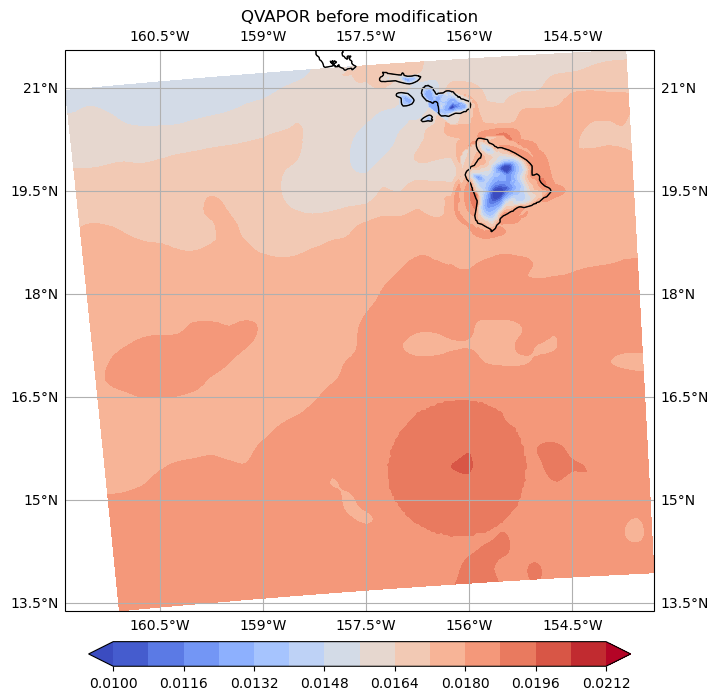

In [6]:
with xr.open_dataset(flnm_wrf) as ds:
    print('Bottom level QVAPOR before modification')
    # ds['QVAPOR'][0, 0].plot(vmin = 0.008, vmax=0.023, cmap='coolwarm')
    plot_2d(lat_2d, lon_2d, ds['QVAPOR'][0, 0], 0.01, 0.022, 'coolwarm', 'QVAPOR before modification')
    qv = ds['QVAPOR'].values
    n_lev = qv.shape[1]
     
    mask_3d = np.zeros((n_lev, n_i, n_j))
    for nl in range(n_lev):
        mask_3d[nl] = mask

    # Multiply arguments element-wise.
    ds['QVAPOR'].values = np.multiply(qv, mask_3d)
    
ds.to_netcdf('modified_qv.nc') # rewrite to netcdf

Bottom level QVAPOR after modification


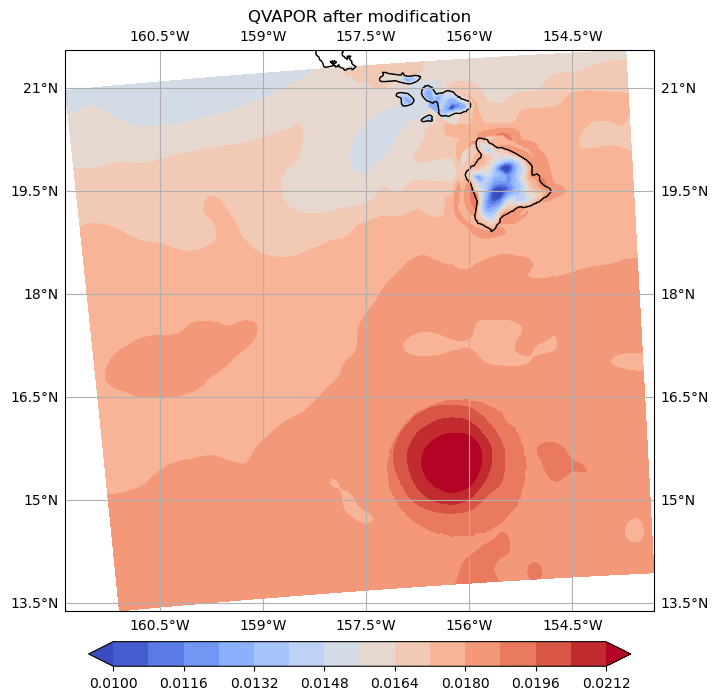

In [7]:
print('Bottom level QVAPOR after modification')
#ds['QVAPOR'][0, 0].plot(vmin = 0.008, vmax=0.023, cmap='coolwarm');
 
plot_2d(lat_2d, lon_2d, ds['QVAPOR'][0, 0], 0.01, 0.022, 'coolwarm', 'QVAPOR after modification')

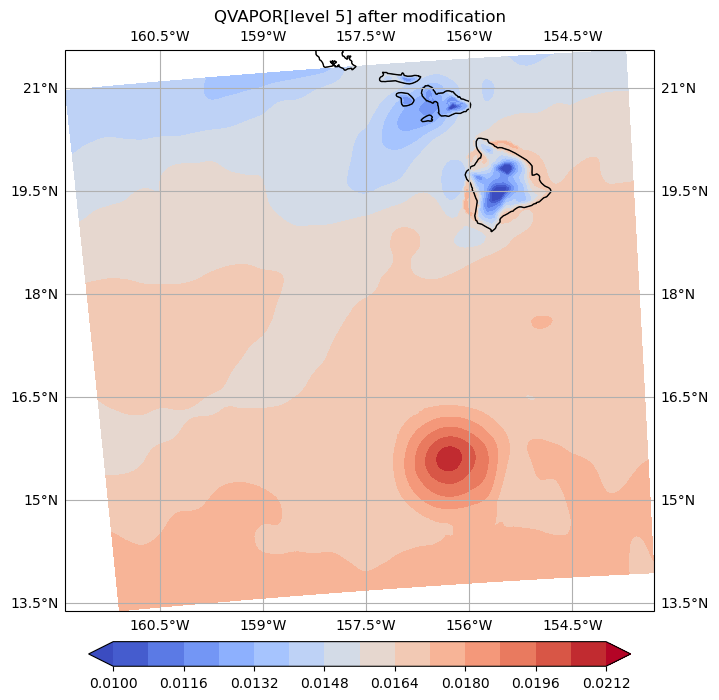

In [11]:
plot_2d(lat_2d, lon_2d, ds['QVAPOR'][0, 5], 0.01, 0.022, 'coolwarm', 'QVAPOR[level 5] after modification')